# Introduction
This notebook summarizes the efforts to train a cryptic binding site predictor with superior performace.

## Baseline
Let's replicate the baseline method from the CryptoBench study as a baseline for our endeavours.

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import sys 

sys.path.append('/home/skrhakv/cryptic-nn/src/models')
import baseline_utils
import finetuning_utils

torch.manual_seed(0)

DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Epoch: 0 | Loss: 2.10593, Accuracy: 94.32% | Test loss: 3.50141, AUC: 0.6011, MCC: 0.0000, F1: 0.9156, AUPRC: 0.0836, sum: 0.0
Epoch: 1 | Loss: 1.65948, Accuracy: 93.71% | Test loss: 1.95734, AUC: 0.8221, MCC: 0.2012, F1: 0.9240, AUPRC: 0.2326, sum: 1246.0
Epoch: 2 | Loss: 1.50099, Accuracy: 92.09% | Test loss: 1.68540, AUC: 0.8695, MCC: 0.3838, F1: 0.9269, AUPRC: 0.3601, sum: 4409.0
Epoch: 3 | Loss: 1.48231, Accuracy: 93.42% | Test loss: 1.65685, AUC: 0.8725, MCC: 0.3836, F1: 0.9340, AUPRC: 0.3740, sum: 3132.0
Epoch: 4 | Loss: 1.42534, Accuracy: 91.96% | Test loss: 1.63469, AUC: 0.8742, MCC: 0.3988, F1: 0.9269, AUPRC: 0.3790, sum: 4702.0
Epoch: 5 | Loss: 1.20505, Accuracy: 93.12% | Test loss: 1.69940, AUC: 0.8711, MCC: 0.3946, F1: 0.9331, AUPRC: 0.3815, sum: 3549.0


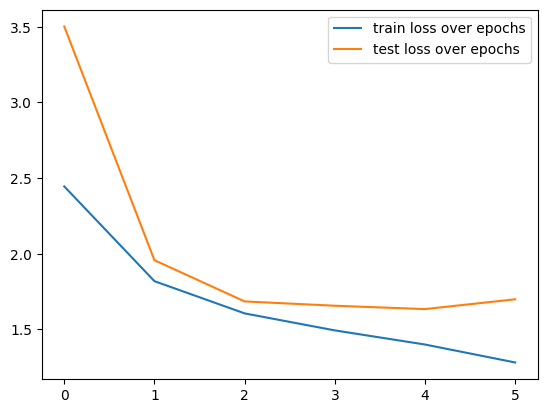

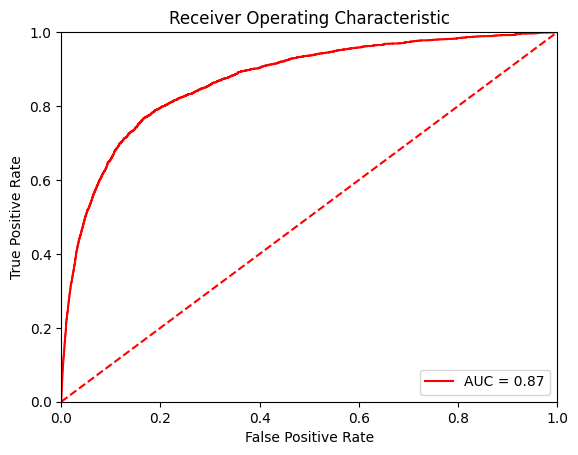

In [2]:
Xs_train_apo, Ys_train_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

baseline_model = baseline_utils.CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=baseline_model.parameters(),
                            lr=0.0001)


baseline_utils.train(baseline_model, optimizer, epochs=6, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo, save_aucroc_auprc_to='baseline-model')


## Determine decision threshold
Check which threshold is optimal to decide between 0 and 1 labels.

In [10]:
import os
import numpy as np
from sklearn import metrics


X, labels, = test_dataset_apo[:]
X = X.to(device)

thresholds = np.arange(0.0, 1.0, 0.05)
for threshold in thresholds:
    predictions = baseline_model(X).squeeze()
    rounded_predictions = (predictions > threshold).cpu().numpy().astype(int)
    acc = metrics.accuracy_score(labels, rounded_predictions)

    mcc = metrics.matthews_corrcoef(labels, rounded_predictions)
    f1 = metrics.f1_score(labels, rounded_predictions, average='weighted')

    print(f"Threshold: {threshold:.2f} | Accuracy: {acc:.4f} | MCC: {mcc:.4f} | F1: {f1:.4f}")

Threshold: 0.00 | Accuracy: 0.6699 | MCC: 0.2527 | F1: 0.7581
Threshold: 0.05 | Accuracy: 0.6749 | MCC: 0.2540 | F1: 0.7619
Threshold: 0.10 | Accuracy: 0.6807 | MCC: 0.2561 | F1: 0.7662
Threshold: 0.15 | Accuracy: 0.6843 | MCC: 0.2558 | F1: 0.7689
Threshold: 0.20 | Accuracy: 0.6895 | MCC: 0.2613 | F1: 0.7728
Threshold: 0.25 | Accuracy: 0.6949 | MCC: 0.2615 | F1: 0.7768
Threshold: 0.30 | Accuracy: 0.6993 | MCC: 0.2629 | F1: 0.7800
Threshold: 0.35 | Accuracy: 0.7060 | MCC: 0.2685 | F1: 0.7849
Threshold: 0.40 | Accuracy: 0.7093 | MCC: 0.2680 | F1: 0.7873
Threshold: 0.45 | Accuracy: 0.7147 | MCC: 0.2714 | F1: 0.7913
Threshold: 0.50 | Accuracy: 0.7194 | MCC: 0.2733 | F1: 0.7946
Threshold: 0.55 | Accuracy: 0.7242 | MCC: 0.2759 | F1: 0.7981
Threshold: 0.60 | Accuracy: 0.7299 | MCC: 0.2791 | F1: 0.8022
Threshold: 0.65 | Accuracy: 0.7330 | MCC: 0.2805 | F1: 0.8043
Threshold: 0.70 | Accuracy: 0.7369 | MCC: 0.2823 | F1: 0.8071
Threshold: 0.75 | Accuracy: 0.7426 | MCC: 0.2874 | F1: 0.8111
Threshol

## Multitask learning
Introduce multitask learning to the baseline method. Use apo-holo distance as a second target and see whether that improves the prediction performance.

In [ ]:
from sklearn.preprocessing import StandardScaler

class MultitaskSequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys_CBS, _Ys_distances, scaler=None):
        
        _Xs_list = []
        _Ys_CBS_list = []
        _Ys_distances_list = []
        for key, _ in _Xs.items():
            _Xs_list.append(_Xs[key])
            _Ys_CBS_list.append(_Ys_CBS[key])
            _Ys_distances_list.append(_Ys_distances[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_CBS_list = np.concatenate(_Ys_CBS_list, axis=0)
        Ys_distances_list = np.concatenate(_Ys_distances_list, axis=0)

        print('Rescaling the distances ...')
        if not scaler:
            self.scaler = StandardScaler()
            self.scaler.fit(Ys_distances_list.reshape(-1, 1))
        else:
            self.scaler = scaler
        
        Ys_distances_list = self.scaler.transform(Ys_distances_list.reshape(-1, 1)).reshape(1, -1)[0]
        
        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys_CBS = torch.tensor(Ys_CBS_list, dtype=torch.int16)
        self.Ys_distances = torch.tensor(Ys_distances_list, dtype=torch.float32)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys_CBS)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y_CBS = self.Ys_CBS[idx]
        y_distance = self.Ys_distances[idx]
        return x, y_CBS, y_distance

def multitask_process_sequence_dataset(annotation_path, embeddings_paths, distances_path):
    Xs = {}
    Ys_CBS = {}
    Ys_distances = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys_CBS:
                Ys_CBS[id] = np.zeros(embedding.shape[0])
                distances = np.load(f'{distances_path}/{id}.npy')
                # set the unknown value (-1) to something more reasonable:
                distances[distances == -1] = 0.5
                Ys_distances[id] = distances

                assert len(Ys_CBS[id]) == len(Ys_distances[id])
            
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys_CBS[id][residue_idx] = 1

    return Xs, Ys_CBS, Ys_distances


DROPOUT = 0.5
LAYER_WIDTH = 300
ESM2_DIM = 2560

class MultitaskCryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout3 = nn.Dropout(DROPOUT)

        self.layer_4_CBS = nn.Linear(in_features=LAYER_WIDTH, out_features=1)
        self.layer_4_distance = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout3(self.relu(self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))))
        return self.layer_4_CBS(x), self.layer_4_distance(x)
    
def multitask_train(model, optimizer, epochs, batch_size, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train_cbs, _ = train_dataset[:]
    X_test, y_test_cbs, _ = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    cbs_class_weights = baseline_utils.compute_class_weights(y_train_cbs.numpy()).to(device)

    # BCEWithLogitsLoss - sigmoid is already built-in!
    cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=cbs_class_weights[1])
    distances_loss_fn = nn.MSELoss()

    X_test, y_test_cbs = X_test.to(device), y_test_cbs.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits, _ = model(X_test)
            test_logits = test_logits.squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = cbs_loss_fn(test_logits,
                                y_test_cbs)
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=y_test_cbs,
                                   y_pred=test_pred)
            fpr, tpr, _ = metrics.roc_curve(y_test_cbs.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test_cbs.cpu().numpy(), test_pred.cpu().numpy())

            f1 = metrics.f1_score(y_test_cbs.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')

            precision, recall, _ = metrics.precision_recall_curve(y_test_cbs.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)

        #
        # TRAIN
        #
        batch_losses = []
        for x_batch, y_batch_cbs, y_batch_distances in train_dataloader:

            x_batch = x_batch.to(device)
            y_batch_cbs = y_batch_cbs.to(device).float()
            y_batch_distances = y_batch_distances.to(device).float()
            model.train()

            y_logits_cbs, y_logits_distance = model(x_batch)
            y_logits_cbs, y_logits_distance = y_logits_cbs.squeeze(), y_logits_distance.squeeze()

            cbs_loss = cbs_loss_fn(y_logits_cbs,
                           y_batch_cbs)
            distance_loss = distances_loss_fn(y_logits_distance, y_batch_distances)

            loss = cbs_loss + distance_loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(cbs_loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Distance loss: {distance_loss:.4f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    plt.plot(train_losses,label="CBS train loss over epochs")
    plt.plot(test_losses,label="CBS test loss over epochs")
    plt.legend()
    plt.show()

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


Concatenating ...
Rescaling the distances ...
Converting to torch tensor ...
Concatenating ...
Rescaling the distances ...
Converting to torch tensor ...
Epoch: 0 | Loss: 1.96470, Distance loss: 1.2208, Accuracy: 5.68% | Test loss: 1.00733, AUC: 0.4581, MCC: 0.0000, F1: 0.0061, AUPRC: 0.0538, sum: 55572.0
Epoch: 1 | Loss: 1.64793, Distance loss: 1.0311, Accuracy: 88.77% | Test loss: 0.72300, AUC: 0.8392, MCC: 0.3106, F1: 0.9047, AUPRC: 0.2389, sum: 6349.0
Epoch: 2 | Loss: 1.26622, Distance loss: 0.6956, Accuracy: 86.09% | Test loss: 0.60453, AUC: 0.8725, MCC: 0.3720, F1: 0.8906, AUPRC: 0.3595, sum: 9164.0
Epoch: 3 | Loss: 1.14917, Distance loss: 0.5695, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
Epoch: 4 | Loss: 1.19628, Distance loss: 0.5519, Accuracy: 88.92% | Test loss: 0.59467, AUC: 0.8774, MCC: 0.3943, F1: 0.9087, AUPRC: 0.3962, sum: 7240.0
Epoch: 5 | Loss: 1.06053, Distance loss: 0.5419, Accuracy: 87.74% | Test loss: 0.

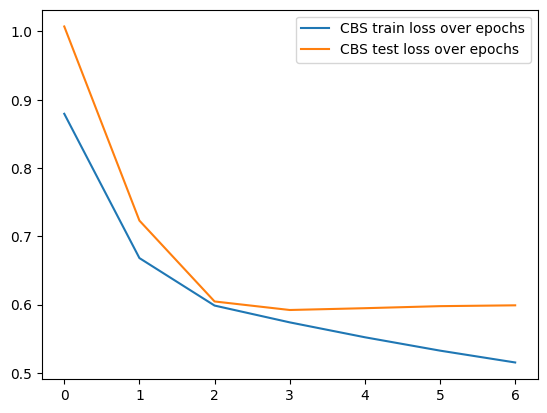

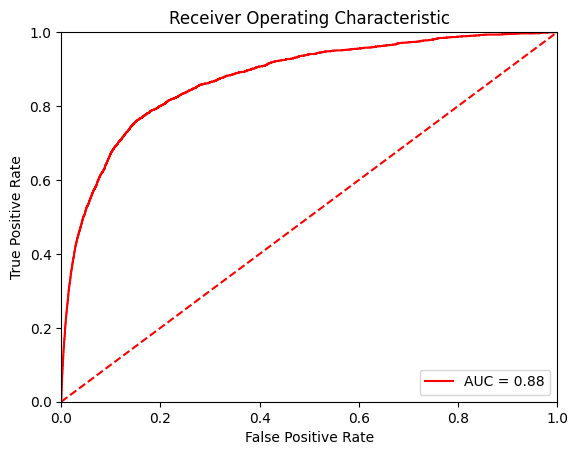

In [ ]:
DISTANCES_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}/residue-distances'

Xs_train, Ys_train_CBS, Ys_train_distances = baseline_utils.process_sequence_dataset(f'{DATA_PATH}/train.txt', [ESM_EMBEDDINGS_PATH], distances_path=DISTANCES_PATH)
train_dataset = MultitaskSequenceCryptoBenchDataset(Xs_train, Ys_train_CBS, Ys_train_distances)

Xs_test, Ys_test_CBS, Ys_test_distances = baseline_utils.process_sequence_dataset(f'{DATA_PATH}/test.txt', [ESM_EMBEDDINGS_PATH], distances_path=DISTANCES_PATH)
test_dataset = MultitaskSequenceCryptoBenchDataset(Xs_test, Ys_test_CBS, Ys_test_distances, scaler=train_dataset.scaler)

multitask_model = MultitaskCryptoBenchClassifier().to(device)
optimizer = torch.optim.Adam(params=multitask_model.parameters(),
                            lr=0.0001)
multitask_train(multitask_model, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset, test_dataset=test_dataset)

# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0


## Remove non-cryptic binding residues
Proteins might contain non-cryptic binding residues. Those might skew the model training and evaluation. Let's remove them from both train set and test set.

### Baseline method
First, let's try this approach for the baseline method.

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Epoch: 0 | Loss: 2.13452, Accuracy: 94.14% | Test loss: 3.34343, AUC: 0.5559, MCC: 0.0000, F1: 0.9130, AUPRC: 0.0693, sum: 0.0
Epoch: 1 | Loss: 1.70039, Accuracy: 93.59% | Test loss: 1.94677, AUC: 0.8273, MCC: 0.2365, F1: 0.9243, AUPRC: 0.2561, sum: 1421.0
Epoch: 2 | Loss: 1.59091, Accuracy: 92.52% | Test loss: 1.65191, AUC: 0.8757, MCC: 0.4093, F1: 0.9297, AUPRC: 0.3964, sum: 4101.0
Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
Epoch: 4 | Loss: 1.32184, Accuracy: 92.33% | Test loss: 1.60831, AUC: 0.8796, MCC: 0.4228, F1: 0.9292, AUPRC: 0.4167, sum: 4442.0
Epoch: 5 | Loss: 1.25947, Accuracy: 92.49% | Test loss: 1.67830, AUC: 0.8777, MCC: 0.4226, F1: 0.9302, AUPRC: 0.4198, sum: 4288.0
Epoch: 6 | Loss: 0.89797, Accuracy: 92.11% | Test loss: 1.76438, AUC: 0.8761, MCC: 0.4176, F1: 0.9278, AUPRC: 0.4246, sum: 45

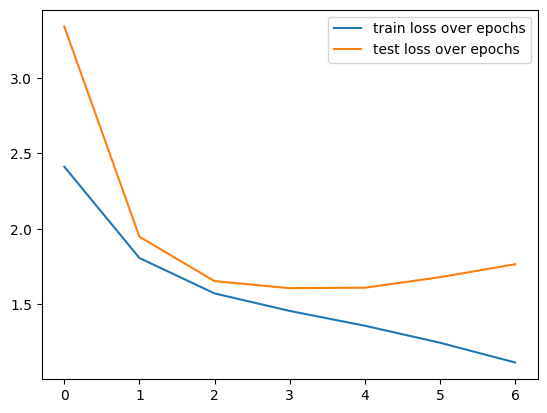

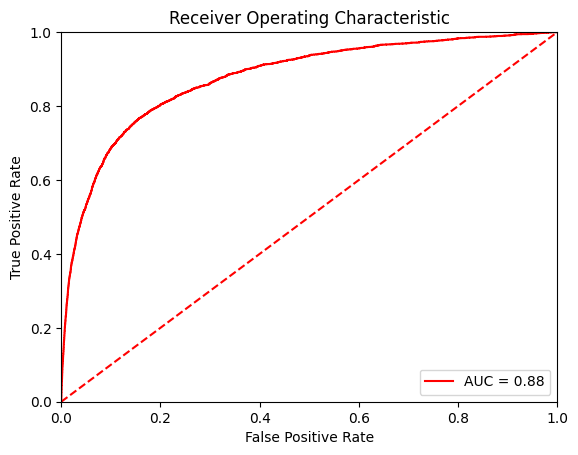

In [ ]:
NONCRYPTIC_ANNOTATIONS_PATH = '/home/skrhakv/cryptic-nn/data/non-cryptic-cryptobench/noncryptic-annotations.txt'

Xs_train_apo, Ys_train_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', [ESM_EMBEDDINGS_PATH], noncryptic_annotation_path=NONCRYPTIC_ANNOTATIONS_PATH)
train_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', [ESM_EMBEDDINGS_PATH], noncryptic_annotation_path=NONCRYPTIC_ANNOTATIONS_PATH)
test_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

baseline_model = baseline_utils.CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=baseline_model.parameters(),
                            lr=0.0001)

baseline_utils.train(baseline_model, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0

### Multitask method
Let's try the same for the multitask method - remove the noncryptic residues from both train set and test set.

Concatenating ...
Rescaling the distances ...
Converting to torch tensor ...
Concatenating ...
Rescaling the distances ...
Converting to torch tensor ...
Epoch: 0 | Loss: 1.96895, Distance loss: 1.1312, Accuracy: 94.14% | Test loss: 0.99023, AUC: 0.5955, MCC: 0.0000, F1: 0.9130, AUPRC: 0.0871, sum: 0.0
Epoch: 1 | Loss: 1.69847, Distance loss: 1.0386, Accuracy: 89.89% | Test loss: 0.72748, AUC: 0.8399, MCC: 0.3166, F1: 0.9106, AUPRC: 0.2568, sum: 5301.0
Epoch: 2 | Loss: 1.47900, Distance loss: 0.9095, Accuracy: 86.76% | Test loss: 0.59632, AUC: 0.8755, MCC: 0.3837, F1: 0.8943, AUPRC: 0.3815, sum: 8518.0
Epoch: 3 | Loss: 1.65389, Distance loss: 1.1084, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0
Epoch: 4 | Loss: 1.18018, Distance loss: 0.6568, Accuracy: 87.93% | Test loss: 0.58104, AUC: 0.8823, MCC: 0.4028, F1: 0.9021, AUPRC: 0.4371, sum: 7871.0
Epoch: 5 | Loss: 1.27609, Distance loss: 0.7362, Accuracy: 87.45% | Test loss: 0.580

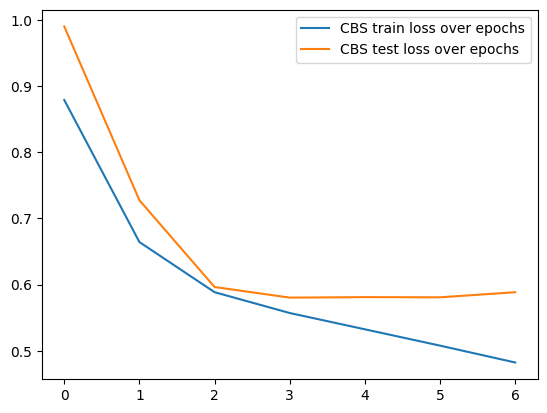

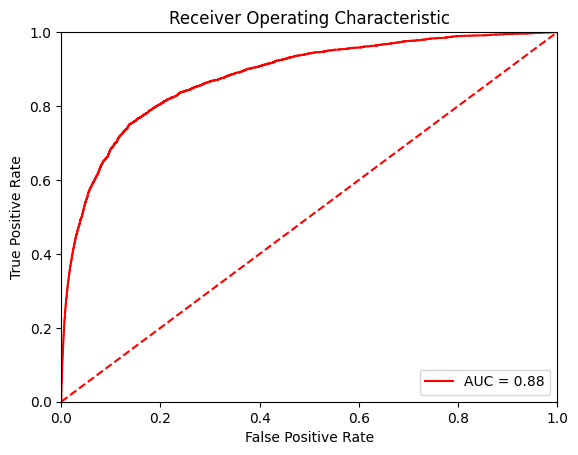

In [ ]:
DISTANCES_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}/residue-distances'
NONCRYPTIC_ANNOTATIONS_PATH = '/home/skrhakv/cryptic-nn/data/non-cryptic-cryptobench/noncryptic-annotations.txt'

Xs_train, Ys_train_CBS, Ys_train_distances = baseline_utils.process_sequence_dataset(f'{DATA_PATH}/train.txt', [ESM_EMBEDDINGS_PATH], distances_path=DISTANCES_PATH, noncryptic_annotation_path=NONCRYPTIC_ANNOTATIONS_PATH)
train_dataset = MultitaskSequenceCryptoBenchDataset(Xs_train, Ys_train_CBS, Ys_train_distances)

Xs_test, Ys_test_CBS, Ys_test_distances = baseline_utils.process_sequence_dataset(f'{DATA_PATH}/test.txt', [ESM_EMBEDDINGS_PATH], distances_path=DISTANCES_PATH, noncryptic_annotation_path=NONCRYPTIC_ANNOTATIONS_PATH)
test_dataset = MultitaskSequenceCryptoBenchDataset(Xs_test, Ys_test_CBS, Ys_test_distances, scaler=train_dataset.scaler)

multitask_model = MultitaskCryptoBenchClassifier().to(device)
optimizer = torch.optim.Adam(params=multitask_model.parameters(),
                            lr=0.0001)
multitask_train(multitask_model, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset, test_dataset=test_dataset)

# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
#
# multitask_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.65389, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0

## Create smoothing classifier
After visual inspection, the pockets predicted by the pLM models often contain holes in the pocket and the pocket surface is not smooth. Let's implement a classifier for that.

In [39]:
POSITIVE_DISTANCE_THRESHOLD = 15
NEGATIVE_DISTANCE_THRESHOLD = 10

def process_sequence_dataset_for_smoothing(annotation_path, embeddings_path, distance_matrices_path, perform_assertions=True):
    Xs = {}
    Ys = {}
    idx = {}

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            if perform_assertions:
                sequence = row[4]

            if row[3] == '':
                continue
            
            assert id not in Xs
            assert id not in Ys
            Xs[id] = []
            Ys[id] = []
            idx[id] = []

            # load the precomputed embedding
            filename = id + '.npy'
            embedding = np.load(f'{embeddings_path}/{filename}')
            
            # load the distance matrix
            distance_matrix = np.load(f'{distance_matrices_path}/{id}.npy')

            negative_examples_indices = set()
            binding_residues_indices = [int(residue[1:]) for residue in row[3].split(' ')]
            
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                if perform_assertions:
                    assert sequence[residue_idx] == aa
                # check if the distance of the residue to all other residues is less than the threshold
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                # get residues that are close to the current residue and are binding residues
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)
                
                # create embedding by aggregating the embeddings of the close binding residues
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(1) # positive example
                idx[id].append(residue_idx)
                
                # Let's get negative examples:
                # add those that are really close to the binding residues (i.e. within NEGATIVE_DISTANCE_THRESHOLD) but are not binding residues
                really_close_residues_indices = np.where(distance_matrix[residue_idx] < NEGATIVE_DISTANCE_THRESHOLD)[0]
                # add non-binding residues to the list of negatives (that's the exclusive left join of really_close_residues_indices and binding_residues_indices)
                negative_examples_indices.update(set(list(really_close_residues_indices)) - set(list(binding_residues_indices)))

            # add negative examples - create the embeddings 
            for residue_idx in negative_examples_indices:
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)

                # create embedding 
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(0) # negative example
                idx[id].append(residue_idx)

    return Xs, Ys, idx

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Epoch: 0 | Loss: 2.18233, Accuracy: 81.04% | Test loss: 3.29565, AUC: 0.5428, MCC: 0.0000, F1: 0.7255, AUPRC: 0.2106, sum: 0.0
Epoch: 1 | Loss: 2.04517, Accuracy: 37.13% | Test loss: 2.16351, AUC: 0.5875, MCC: 0.0665, F1: 0.3946, AUPRC: 0.2437, sum: 12390.0
Epoch: 2 | Loss: 1.97632, Accuracy: 58.00% | Test loss: 2.05852, AUC: 0.6855, MCC: 0.2113, F1: 0.6247, AUPRC: 0.3308, sum: 8402.0
Epoch: 3 | Loss: 1.82657, Accuracy: 60.47% | Test loss: 1.93556, AUC: 0.7747, MCC: 0.3082, F1: 0.6458, AUPRC: 0.4079, sum: 8756.0
Epoch: 4 | Loss: 1.69359, Accuracy: 67.10% | Test loss: 1.78553, AUC: 0.8043, MCC: 0.3628, F1: 0.7065, AUPRC: 0.4383, sum: 7537.0
Epoch: 5 | Loss: 1.66216, Accuracy: 72.22% | Test loss: 1.67765, AUC: 0.8283, MCC: 0.4104, F1: 0.7509, AUPRC: 0.4787, sum: 6586.0
Epoch: 6 | Loss: 1.52489, Accuracy: 72.46% | Test loss: 1.60570, AUC: 0.8403, MCC: 0.4198, F1: 0.7531, AUPRC: 0.5064, sum: 6

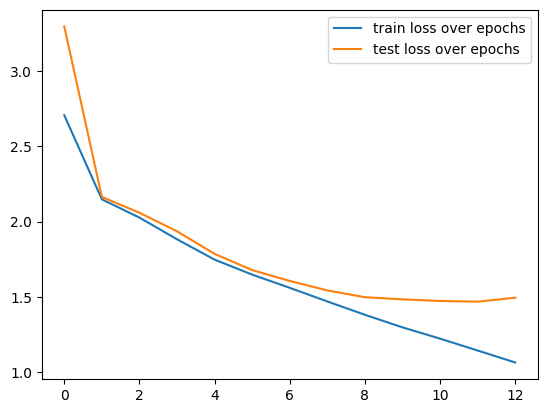

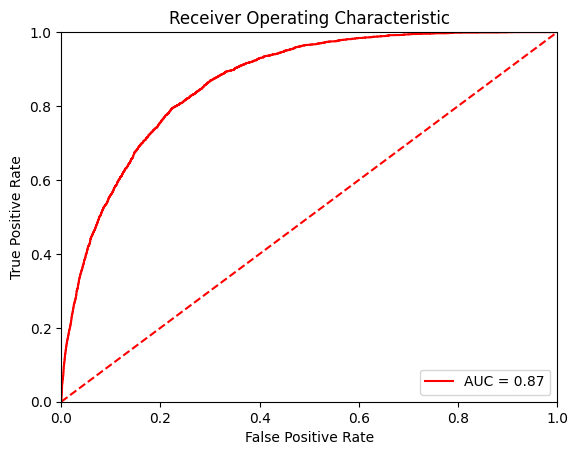

In [ ]:
DISTANCE_MATRICES_PATH = f'{DATA_PATH}/distance-matrices'
SMOOTHING_DECISION_THRESHOLD = 0.8

smoothing_model = baseline_utils.CryptoBenchClassifier(input_dim=2 * ESM2_DIM).to(device)
optimizer = torch.optim.AdamW(params=smoothing_model.parameters(),
                            lr=0.0001)

Xs_train_apo, Ys_train_apo, _ = process_sequence_dataset_for_smoothing(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
train_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo, _ = process_sequence_dataset_for_smoothing(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
test_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

baseline_utils.train(smoothing_model, optimizer, epochs=13, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo, decision_threshold=SMOOTHING_DECISION_THRESHOLD)

### Combine smoothing classifier with baseline method
Let's take the predictions of the baseline method, smoothen it using the smoothing classifier, and assess whether the smoothing helps.

In [ ]:
def train_with_smoothing(model, optimizer, epochs, batch_size, train_dataset, test_dataset, smoothing_model):
    test_removed_indices = None
    if len(test_dataset) == 2:
        (Xs_test, Ys_test) = test_dataset[:]
    elif len(test_dataset) == 3:
        (Xs_test, Ys_test, test_removed_indices) = test_dataset[:]
        
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = baseline_utils.compute_class_weights(y_train.numpy()).to(device)

    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=8 * class_weights[1])

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #

        model.eval()
        smoothing_model.eval()
        with torch.inference_mode():
            all_test_logits = []
            all_test_pred = []
            all_y_test = []
            this_test_losses = []

            for protein_id in Xs_test.keys():
                X_test = torch.tensor(Xs_test[protein_id], dtype=torch.float32).to(device)
                y_test = torch.tensor(Ys_test[protein_id], dtype=torch.int64).to(device).float()

                test_logits = model(X_test).squeeze()
                all_test_logits.append(test_logits.cpu().detach().numpy())
                # test_pred = torch.round(torch.sigmoid(test_logits))
                test_pred = (torch.sigmoid(test_logits)>baseline_utils.DECISION_THRESHOLD).float()
                
                test_loss = loss_fn(test_logits,
                                    y_test)
                this_test_losses.append(test_loss.cpu().detach().numpy())

                test_pred_copy = test_pred.clone().detach().cpu().numpy()
                # let's use the smoothing model here:
                # first, get the distance matrix
                distance_matrix = np.load(f'{DISTANCE_MATRICES_PATH}/{protein_id}.npy')
                if test_removed_indices and protein_id in test_removed_indices:
                    distance_matrix = np.delete(distance_matrix, test_removed_indices[protein_id], axis=0)
                    distance_matrix = np.delete(distance_matrix, test_removed_indices[protein_id], axis=1)
                assert distance_matrix.shape[0] == distance_matrix.shape[1]
                assert distance_matrix.shape[0] == len(y_test)
                
                # loop over the residues that are not binding and are potential candidates for smoothing
                for residue_idx in torch.where(test_pred == 0)[0]:
                    # get the embedding of the residue
                    current_residue_embedding = X_test[residue_idx].cpu().numpy()

                    # get the close binding residues
                    close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                    close_binding_residues_indices = np.intersect1d(close_residues_indices, torch.where(y_test == 1)[0].cpu().numpy())

                    # create embedding 
                    if len(close_binding_residues_indices) == 0:
                        # no close binding residues - skip this residue
                        continue
                    elif len(close_binding_residues_indices) == 1:
                        surrounding_embedding = X_test[close_binding_residues_indices].cpu().numpy().reshape(-1)
                    else:
                        # get the mean of the close binding residues
                        surrounding_embedding = np.mean(X_test[close_binding_residues_indices].cpu().numpy(), axis=0).reshape(-1)

                    concatenated_embedding = torch.tensor(np.concatenate((current_residue_embedding, surrounding_embedding), axis=0), dtype=torch.float32).to(device)
                    
                    # get the prediction
                    test_logits = smoothing_model(concatenated_embedding).squeeze()
                    result = (torch.sigmoid(test_logits)>SMOOTHING_DECISION_THRESHOLD).float()
                    if result == 1:
                        # set the residue as binding
                        test_pred_copy[residue_idx] = 1
                
                all_y_test.append(y_test.cpu().detach().numpy())
                all_test_pred.append(test_pred_copy)
            
            test_loss = sum(this_test_losses) / len(this_test_losses)
            test_losses.append(test_loss)
            test_logits = torch.tensor(np.concatenate(all_test_logits, axis=0), dtype=torch.float32).to(device)
            test_pred = torch.tensor(np.concatenate(all_test_pred, axis=0), dtype=torch.float32).to(device)
            y_test = torch.tensor(np.concatenate(all_y_test, axis=0), dtype=torch.float32).to(device)
            
            # Compute AUPRC and ROC AUC without using the smoothing model
            fpr, tpr, _ = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            precision, recall, _ = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')


        #
        # TRAIN
        #
        batch_losses = []
        for x_batch, y_batch in train_dataloader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()

            loss = loss_fn(y_logits,
                           y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    plt.plot(train_losses,label="train loss over epochs")
    plt.plot(test_losses,label="test loss over epochs")
    plt.legend()
    plt.show()

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


Concatenating ...
Converting to torch tensor ...
Epoch: 0 | Loss: 1.96151, Accuracy: 89.36% | Test loss: 3.99652, AUC: 0.5333, MCC: 0.4864, F1: 0.9143, AUPRC: 0.0640, sum: 8091.0
Epoch: 1 | Loss: 1.66248, Accuracy: 88.73% | Test loss: 2.10725, AUC: 0.8204, MCC: 0.4755, F1: 0.9100, AUPRC: 0.2288, sum: 8464.0
Epoch: 2 | Loss: 1.59966, Accuracy: 87.58% | Test loss: 1.79778, AUC: 0.8694, MCC: 0.4556, F1: 0.9022, AUPRC: 0.3574, sum: 9126.0
Epoch: 3 | Loss: 1.45075, Accuracy: 87.19% | Test loss: 1.73259, AUC: 0.8748, MCC: 0.4495, F1: 0.8996, AUPRC: 0.3744, sum: 9346.0
Epoch: 4 | Loss: 1.35479, Accuracy: 87.09% | Test loss: 1.75164, AUC: 0.8749, MCC: 0.4481, F1: 0.8989, AUPRC: 0.3780, sum: 9411.0
Epoch: 5 | Loss: 1.14354, Accuracy: 86.92% | Test loss: 1.83135, AUC: 0.8703, MCC: 0.4451, F1: 0.8978, AUPRC: 0.3770, sum: 9503.0
Epoch: 6 | Loss: 1.31822, Accuracy: 87.71% | Test loss: 2.10269, AUC: 0.8672, MCC: 0.4568, F1: 0.9031, AUPRC: 0.3801, sum: 9036.0


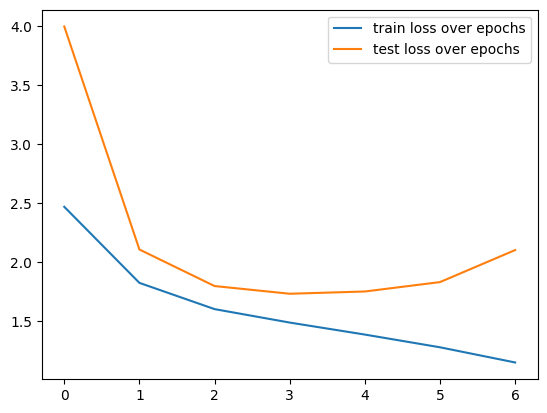

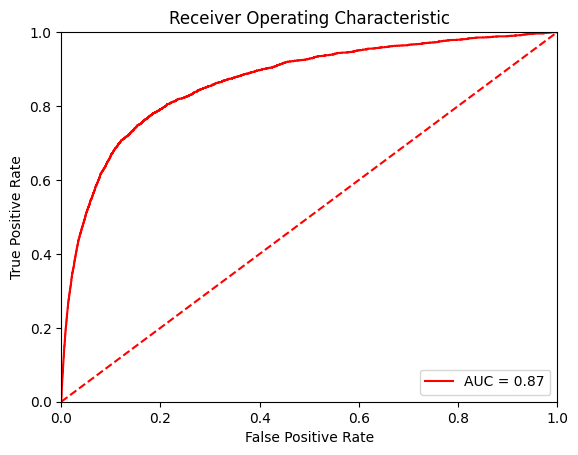

In [ ]:
Xs_train_apo, Ys_train_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', [ESM_EMBEDDINGS_PATH])

baseline_model = baseline_utils.CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=baseline_model.parameters(),
                            lr=0.0001)

train_with_smoothing(baseline_model, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=(Xs_test_apo, Ys_test_apo), smoothing_model=smoothing_model)


# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
#
# multitask_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.65389, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0
#
# baseline_model with smoothing:
# Epoch: 3 | Loss: 1.45075, Accuracy: 87.19% | Test loss: 1.73259, AUC: 0.8748, MCC: 0.4495, F1: 0.8996, AUPRC: 0.3744, sum: 9346.0

### Remove non-cryptic residues when using smoothing classifier
Now, let's combine the approach of removing non-cryptic residues and the usage of the smoothing classifier.

Concatenating ...
Converting to torch tensor ...
Epoch: 0 | Loss: 1.89010, Accuracy: 90.02% | Test loss: 4.09586, AUC: 0.4655, MCC: 0.5062, F1: 0.9184, AUPRC: 0.0547, sum: 7554.0
Epoch: 1 | Loss: 1.66009, Accuracy: 89.36% | Test loss: 2.11377, AUC: 0.8252, MCC: 0.4938, F1: 0.9139, AUPRC: 0.2489, sum: 7941.0
Epoch: 2 | Loss: 1.70785, Accuracy: 88.53% | Test loss: 1.82840, AUC: 0.8745, MCC: 0.4788, F1: 0.9082, AUPRC: 0.3945, sum: 8409.0
Epoch: 3 | Loss: 1.35203, Accuracy: 87.69% | Test loss: 1.73996, AUC: 0.8823, MCC: 0.4651, F1: 0.9025, AUPRC: 0.4128, sum: 8884.0
Epoch: 4 | Loss: 1.37367, Accuracy: 88.06% | Test loss: 1.78085, AUC: 0.8808, MCC: 0.4705, F1: 0.9050, AUPRC: 0.4202, sum: 8670.0
Epoch: 5 | Loss: 1.26288, Accuracy: 88.42% | Test loss: 1.88721, AUC: 0.8762, MCC: 0.4753, F1: 0.9074, AUPRC: 0.4218, sum: 8451.0
Epoch: 6 | Loss: 1.13748, Accuracy: 88.07% | Test loss: 2.06480, AUC: 0.8743, MCC: 0.4700, F1: 0.9050, AUPRC: 0.4261, sum: 8653.0


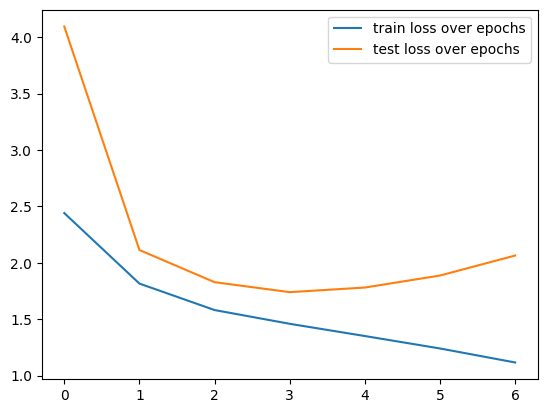

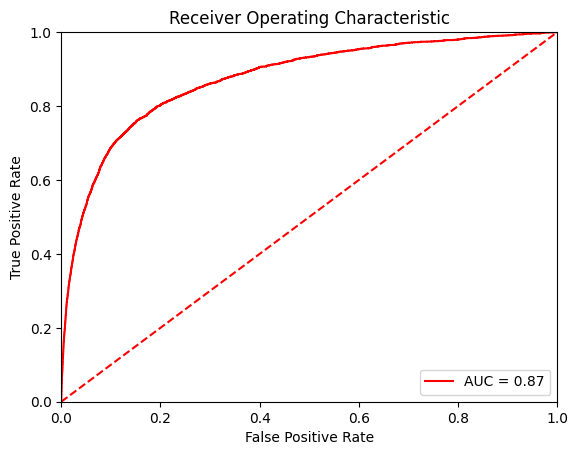

In [ ]:
Xs_train_apo, Ys_train_apo, _ = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', [ESM_EMBEDDINGS_PATH], noncryptic_annotation_path=NONCRYPTIC_ANNOTATIONS_PATH)
train_dataset_apo = baseline_utils.SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo, test_removed_indices = baseline_utils.process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', [ESM_EMBEDDINGS_PATH], noncryptic_annotation_path=NONCRYPTIC_ANNOTATIONS_PATH)

baseline_model = baseline_utils.CryptoBenchClassifier().to(device)
optimizer = torch.optim.AdamW(params=baseline_model.parameters(),
                            lr=0.0001)

train_with_smoothing(baseline_model, optimizer, epochs=7, batch_size=2048, 
      train_dataset=train_dataset_apo, test_dataset=(Xs_test_apo, Ys_test_apo, test_removed_indices), smoothing_model=smoothing_model)

# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
#
# multitask_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.65389, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0
#
# baseline_model with smoothing:
# Epoch: 3 | Loss: 1.45075, Accuracy: 87.19% | Test loss: 1.73259, AUC: 0.8748, MCC: 0.4495, F1: 0.8996, AUPRC: 0.3744, sum: 9346.0
# 
# baseline_model with smoothing without non-cryptic residues:
# Epoch: 5 | Loss: 1.26288, Accuracy: 88.42% | Test loss: 1.88721, AUC: 0.8762, MCC: 0.4753, F1: 0.9074, AUPRC: 0.4218, sum: 8451.0




These were models leveraging simple transfer learning, e.g., taking embedding from pretrained model and training a separate neural network.

## Finetuning ESM2 model
Let's move away from transfer learning and let's finetune the whole ESM2 model.

In [2]:
from transformers import EsmModel, AutoTokenizer
import torch
import torch.nn as nn
import numpy as np
import csv
from datasets import Dataset
import functools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import gc
import bitsandbytes as bnb
from torch.utils.data import DataLoader
import warnings

warnings.filterwarnings('ignore')
torch.manual_seed(42)
MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'


In [3]:
finetuned_model = finetuning_utils.FinetunedEsmModel(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:

            output = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output = finetuned_model(batch)

        labels = batch['labels'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        loss =  loss_fn(cbs_logits, valid_flattened_labels)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
#
# multitask_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.65389, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0
#
# baseline_model with smoothing:
# Epoch: 3 | Loss: 1.45075, Accuracy: 87.19% | Test loss: 1.73259, AUC: 0.8748, MCC: 0.4495, F1: 0.8996, AUPRC: 0.3744, sum: 9346.0
# 
# baseline_model with smoothing without non-cryptic residues:
# Epoch: 5 | Loss: 1.26288, Accuracy: 88.42% | Test loss: 1.88721, AUC: 0.8762, MCC: 0.4753, F1: 0.9074, AUPRC: 0.4218, sum: 8451.0
#
# finetuned_model:
# Epoch: 3 | Loss: 0.19887, Accuracy: 88.72% | Test loss: 0.57126, AUC: 0.8882, MCC: 0.4169, F1: 0.9082, AUPRC: 0.4484, sum: 7690


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 1.06527, Accuracy: 19.73% | Test loss: 1.01993, AUC: 0.4925, MCC: -0.0238, F1: 0.2646, AUPRC: 0.0602, sum: 46510
Epoch: 1 | Loss: 0.73219, Accuracy: 88.71% | Test loss: 0.81390, AUC: 0.8115, MCC: 0.2690, F1: 0.9028, AUPRC: 0.2190, sum: 5926
Epoch: 2 | Loss: 0.67687, Accuracy: 89.69% | Test loss: 0.75158, AUC: 0.8333, MCC: 0.3012, F1: 0.9097, AUPRC: 0.2508, sum: 5515


In [ ]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/base-finetuned-model.pt'
torch.save(finetuned_model, OUTPUT_PATH)


## Multitask learning with ESM2 finetuning
Take the ESM2 model and finetune it on the CryptoBench dataset. Create a second task for predicting residue flexibility. The flexibility is represented by two features: apo-holo distance and pLDDT. pLDDT values were extracted from the AlphaFold database.

In [5]:
distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances'
plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT'


In [6]:
torch.manual_seed(42)

finetuned_model = finetuning_utils.MultitaskFinetunedEsmModel(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', plDDT_path=plDDT_path)
distances_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', distances_path=distances_path)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, distances_scaler=distances_scaler, distances_path=distances_path)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output1, output2, output3 = finetuned_model(batch)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        distance_logits = output3.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  distance_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + distances_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output3, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
#
# multitask_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.65389, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0
#
# baseline_model with smoothing:
# Epoch: 3 | Loss: 1.45075, Accuracy: 87.19% | Test loss: 1.73259, AUC: 0.8748, MCC: 0.4495, F1: 0.8996, AUPRC: 0.3744, sum: 9346.0
# 
# baseline_model with smoothing without non-cryptic residues:
# Epoch: 5 | Loss: 1.26288, Accuracy: 88.42% | Test loss: 1.88721, AUC: 0.8762, MCC: 0.4753, F1: 0.9074, AUPRC: 0.4218, sum: 8451.0
#
# finetuned_model:
# Epoch: 3 | Loss: 0.19887, Accuracy: 88.72% | Test loss: 0.57126, AUC: 0.8882, MCC: 0.4169, F1: 0.9082, AUPRC: 0.4484, sum: 7690
#
# finetuned_model with multitask learning:
# Epoch: 3 | Loss: 0.62206, Accuracy: 89.31% | Test loss: 0.56235, AUC: 0.8885, MCC: 0.4261, F1: 0.9122, AUPRC: 0.4397, sum: 7320

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 0.85853, Accuracy: 19.73% | Test loss: 1.01993, AUC: 0.4925, MCC: -0.0238, F1: 0.2646, AUPRC: 0.0602, sum: 46510
Epoch: 1 | Loss: 0.79319, Accuracy: 89.77% | Test loss: 0.80838, AUC: 0.8111, MCC: 0.2664, F1: 0.9087, AUPRC: 0.2198, sum: 5083
Epoch: 2 | Loss: 0.41769, Accuracy: 87.89% | Test loss: 0.75483, AUC: 0.8315, MCC: 0.2976, F1: 0.8991, AUPRC: 0.2469, sum: 6874


In [7]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/multitask-finetuned-model.pt'
torch.save(finetuned_model, OUTPUT_PATH)
# Epoch: 3 | Loss: 0.62206, Accuracy: 89.31% | Test loss: 0.56235, AUC: 0.8885, MCC: 0.4261, F1: 0.9122, AUPRC: 0.4397, sum: 7320

## Multitask learning + ESM2 finetuning with additional data
Leverage LIGYSIS dataset to obtain more data. Although binding sites in general can be of different nature than cryptic binding sites, use the general BS dataset to pre-finetune the model before applying CryptoBench dataset.

In [ ]:
finetuned_model = finetuning_utils.MultitaskFinetunedEsmModel(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

plDDT_path = '/home/skrhakv/cryptic-nn/data/ligysis/plDDT'
plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', plDDT_path=plDDT_path, uniprot_ids=True)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, uniprot_ids=True)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 4

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss
            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    finetuned_model.train()

    batch_losses = []

    # TRAIN

    for batch in train_dataloader:

        output1, output2, _ = finetuned_model(batch)

        labels = batch['labels'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


## LOAD CRYPTOBENCH DATASET
distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances'
plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT'

plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', plDDT_path=plDDT_path)
distances_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', distances_path=distances_path)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, distances_scaler=distances_scaler, distances_path=distances_path)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 4

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

# similarly train only the classifier for the first few epochs 
for name, param in finetuned_model.named_parameters():
     if name.startswith('llm') or name.startswith('classifier') or name.startswith('plDDT'):
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    finetuned_model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:

        output1, output2, output3 = finetuned_model(batch)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        distance_logits = output3.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  distance_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + distances_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output3, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
#
# multitask_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.65389, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0
#
# baseline_model with smoothing:
# Epoch: 3 | Loss: 1.45075, Accuracy: 87.19% | Test loss: 1.73259, AUC: 0.8748, MCC: 0.4495, F1: 0.8996, AUPRC: 0.3744, sum: 9346.0
# 
# baseline_model with smoothing without non-cryptic residues:
# Epoch: 5 | Loss: 1.26288, Accuracy: 88.42% | Test loss: 1.88721, AUC: 0.8762, MCC: 0.4753, F1: 0.9074, AUPRC: 0.4218, sum: 8451.0
#
# finetuned_model:
# Epoch: 3 | Loss: 0.19887, Accuracy: 88.72% | Test loss: 0.57126, AUC: 0.8882, MCC: 0.4169, F1: 0.9082, AUPRC: 0.4484, sum: 7690
#
# finetuned_model with multitask learning:
# Epoch: 3 | Loss: 0.62206, Accuracy: 89.31% | Test loss: 0.56235, AUC: 0.8885, MCC: 0.4261, F1: 0.9122, AUPRC: 0.4397, sum: 7320
# 
# finetuned_model with multitask learning on cryptobench+ligysis:
# Epoch: 3 | Loss: 0.19425, Accuracy: 89.26% | Test loss: 0.54533, AUC: 0.8956, MCC: 0.4397, F1: 0.9123, AUPRC: 0.4755, sum: 7543


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 0.72350, Accuracy: 19.73% | Test loss: 1.01993, AUC: 0.4925, MCC: -0.0238, F1: 0.2646, AUPRC: 0.0602, sum: 46510
Epoch: 1 | Loss: 0.53515, Accuracy: 84.16% | Test loss: 0.78040, AUC: 0.8033, MCC: 0.2788, F1: 0.8760, AUPRC: 0.2328, sum: 9401
Epoch: 2 | Loss: 0.45756, Accuracy: 82.40% | Test loss: 0.75159, AUC: 0.8211, MCC: 0.2968, F1: 0.8654, AUPRC: 0.2677, sum: 10892
Epoch: 3 | Loss: 0.23589, Accuracy: 85.77% | Test loss: 0.59920, AUC: 0.8811, MCC: 0.3942, F1: 0.8892, AUPRC: 0.4188, sum: 9704
Epoch: 0 | Loss: 0.75070, Accuracy: 80.75% | Test loss: 0.65100, AUC: 0.8834, MCC: 0.3516, F1: 0.8559, AUPRC: 0.4417, sum: 12801
Epoch: 1 | Loss: 0.34551, Accuracy: 80.75% | Test loss: 0.65100, AUC: 0.8834, MCC: 0.3516, F1: 0.8559, AUPRC: 0.4417, sum: 12801
Epoch: 2 | Loss: 0.92496, Accuracy: 80.75% | Test loss: 0.65100, AUC: 0.8834, MCC: 0.3516, F1: 0.8559, AUPRC: 0.4417, sum: 12801
Epoch: 3 | Loss: 0.58936, Accuracy: 89.54% | Test loss: 0.71424, AUC: 0.8203, MCC: 0.3299, F1: 0.9

In [ ]:
with torch.no_grad():
    for batch in val_dataloader:
        output1, _, _ = finetuned_model(batch)

        labels = batch['labels'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

        cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

        test_loss = cbs_test_loss

        test_losses.append(test_loss.cpu().float().detach().numpy())

        # compute metrics on test dataset
        test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                y_pred=predictions)
        fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

        f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

        precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        auprc = metrics.auc(recall, precision)

        del labels, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


Epoch: 3 | Loss: 0.58936, Accuracy: 90.46% | Test loss: 0.53808, AUC: 0.8962, MCC: 0.4513, F1: 0.9200, AUPRC: 0.4911, sum: 6682


In [8]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/multitask-finetuned-model-with-ligysis.pt'
torch.save(finetuned_model, OUTPUT_PATH)
# Epoch: 3 | Loss: 0.58936, Accuracy: 90.46% | Test loss: 0.53808, AUC: 0.8962, MCC: 0.4513, F1: 0.9200, AUPRC: 0.4911, sum: 6682

In [3]:
finetuned_model = finetuning_utils.MultitaskFinetunedEsmModelWithCnn(MODEL_NAME).half().to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

plDDT_path = '/home/skrhakv/cryptic-nn/data/ligysis/plDDT'
plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', plDDT_path=plDDT_path, uniprot_ids=True)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/ligysis/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, uniprot_ids=True)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT', plDDT_scaler=plDDT_scaler)

partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

for name, param in finetuned_model.named_parameters():
     if name.startswith('llm'): 
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    finetuned_model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:

        output1, output2, _ = finetuned_model(batch)

        labels = batch['labels'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


## LOAD CRYPTOBENCH DATASET
distances_path='/home/skrhakv/cryptic-nn/data/cryptobench/residue-distances'
plDDT_path='/home/skrhakv/cryptic-nn/data/cryptobench/plDDT'

plDDT_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', plDDT_path=plDDT_path)
distances_scaler = finetuning_utils.train_scaler('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', distances_path=distances_path)
train_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', tokenizer, plDDT_scaler=plDDT_scaler, plDDT_path=plDDT_path, distances_scaler=distances_scaler, distances_path=distances_path)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer, plDDT_path=plDDT_path, plDDT_scaler=plDDT_scaler)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=partial_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

optimizer = bnb.optim.AdamW8bit(finetuned_model.parameters(), lr=0.0001, eps=1e-4) 

EPOCHS = 3

# precomputed class weights
class_weights = torch.tensor([0.5303, 8.7481], device=device)
cbs_loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
plDDT_loss_fn = nn.MSELoss() 
distance_loss_fn = nn.MSELoss()

# similarly train only the classifier for the first few epochs 
for name, param in finetuned_model.named_parameters():
     if name.startswith('llm') or name.startswith('classifier') or name.startswith('plDDT'):
        param.requires_grad = False

test_losses = []
train_losses = []

for epoch in range(EPOCHS):
    if epoch > 1:
        for name, param in finetuned_model.named_parameters():
            param.requires_grad = True

    finetuned_model.eval()

    # VALIDATION LOOP
    with torch.no_grad():
        for batch in val_dataloader:
            output1, _, _ = finetuned_model(batch)

            labels = batch['labels'].to(device)
    
            flattened_labels = labels.flatten()

            cbs_logits = output1.flatten()[flattened_labels != -100]
            valid_flattened_labels = labels.flatten()[flattened_labels != -100]

            predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

            cbs_test_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)

            test_loss = cbs_test_loss

            test_losses.append(test_loss.cpu().float().detach().numpy())

            # compute metrics on test dataset
            test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                   y_pred=predictions)
            fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

            f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
            auprc = metrics.auc(recall, precision)

            del labels, cbs_logits, valid_flattened_labels, flattened_labels
            gc.collect()
            torch.cuda.empty_cache()
    
    # print('after test')
    # print_used_memory()

    finetuned_model.train()

    batch_losses = []

    # TRAIN

    # TODO: the following row causes the memory explosion
    # with torch.inference_mode():

    for batch in train_dataloader:

        output1, output2, output3 = finetuned_model(batch)

        labels = batch['labels'].to(device)
        distances = batch['distances'].to(device)
        plDDTs = batch['plDDTs'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        plDDT_logits = output2.flatten()[flattened_labels != -100]
        distance_logits = output3.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]
        valid_flattened_distances = distances.flatten()[flattened_labels != -100]
        valid_flattened_plDDTs = plDDTs.flatten()[flattened_labels != -100]

        cbs_loss =  cbs_loss_fn(cbs_logits, valid_flattened_labels)
        distances_loss =  distance_loss_fn(torch.sigmoid(distance_logits), valid_flattened_distances.half())
        plDDT_loss =  plDDT_loss_fn(torch.sigmoid(plDDT_logits), valid_flattened_plDDTs.half())

        loss = cbs_loss + distances_loss + plDDT_loss
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        batch_losses.append(loss.cpu().float().detach().numpy())
        
        del labels, output1, output3, cbs_logits, distance_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()

    train_losses.append(sum(batch_losses) / len(batch_losses))
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


# Record during the lowest test loss:
#
# baseline_model:
# Epoch: 3 | Loss: 1.49315, Accuracy: 92.48% | Test loss: 1.62184, AUC: 0.8749, MCC: 0.3927, F1: 0.9295, AUPRC: 0.3738, sum: 4146.0
#
# multitask_model:
# Epoch: 3 | Loss: 1.14917, Accuracy: 87.17% | Test loss: 0.59204, AUC: 0.8775, MCC: 0.3836, F1: 0.8976, AUPRC: 0.3877, sum: 8490.0
#
# baseline_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.61675, Accuracy: 92.38% | Test loss: 1.60537, AUC: 0.8783, MCC: 0.4153, F1: 0.9292, AUPRC: 0.4066, sum: 4307.0
#
# multitask_model without non-cryptic residues:
# Epoch: 3 | Loss: 1.65389, Accuracy: 86.85% | Test loss: 0.58028, AUC: 0.8829, MCC: 0.3921, F1: 0.8951, AUPRC: 0.4218, sum: 8562.0
#
# baseline_model with smoothing:
# Epoch: 3 | Loss: 1.45075, Accuracy: 87.19% | Test loss: 1.73259, AUC: 0.8748, MCC: 0.4495, F1: 0.8996, AUPRC: 0.3744, sum: 9346.0
# 
# baseline_model with smoothing without non-cryptic residues:
# Epoch: 5 | Loss: 1.26288, Accuracy: 88.42% | Test loss: 1.88721, AUC: 0.8762, MCC: 0.4753, F1: 0.9074, AUPRC: 0.4218, sum: 8451.0
#
# finetuned_model:
# Epoch: 3 | Loss: 0.19887, Accuracy: 88.72% | Test loss: 0.57126, AUC: 0.8882, MCC: 0.4169, F1: 0.9082, AUPRC: 0.4484, sum: 7690
#
# finetuned_model with multitask learning:
# Epoch: 3 | Loss: 0.62206, Accuracy: 89.31% | Test loss: 0.56235, AUC: 0.8885, MCC: 0.4261, F1: 0.9122, AUPRC: 0.4397, sum: 7320
# 
# finetuned_model with multitask learning on cryptobench+ligysis:
# Epoch: 3 | Loss: 0.19425, Accuracy: 89.26% | Test loss: 0.54533, AUC: 0.8956, MCC: 0.4397, F1: 0.9123, AUPRC: 0.4755, sum: 7543
# 
# finetuned_model with multitask learning on cryptobench+ligysis with CNN:
# Epoch: 3 | Loss: 0.31697, Accuracy: 90.56% | Test loss: 0.61663, AUC: 0.8633, MCC: 0.4162, F1: 0.9194, AUPRC: 0.4322, sum: 6143
#
# GAT:
# Epoch: 5 | Loss: 0.29734, Accuracy: 92.33% | Test loss: 0.61743, AUC: 0.8696, MCC: 0.3796, F1: 0.9281, AUPRC: 0.3576, sum: 4137


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0 | Loss: 0.49651, Accuracy: 39.79% | Test loss: 1.02308, AUC: 0.4758, MCC: -0.0238, F1: 0.5229, AUPRC: 0.0548, sum: 33851
Epoch: 1 | Loss: 1.12666, Accuracy: 81.53% | Test loss: 0.80564, AUC: 0.7875, MCC: 0.2605, F1: 0.8590, AUPRC: 0.2241, sum: 11036
Epoch: 2 | Loss: 1.04292, Accuracy: 80.17% | Test loss: 0.78241, AUC: 0.7988, MCC: 0.2697, F1: 0.8505, AUPRC: 0.2458, sum: 12104
Epoch: 0 | Loss: 0.38424, Accuracy: 82.35% | Test loss: 0.65458, AUC: 0.8664, MCC: 0.3498, F1: 0.8663, AUPRC: 0.4043, sum: 11635
Epoch: 1 | Loss: 0.96531, Accuracy: 83.12% | Test loss: 0.63284, AUC: 0.8744, MCC: 0.3625, F1: 0.8715, AUPRC: 0.4228, sum: 11249
Epoch: 2 | Loss: 1.30842, Accuracy: 84.64% | Test loss: 0.62540, AUC: 0.8689, MCC: 0.3709, F1: 0.8814, AUPRC: 0.4129, sum: 10241


In [5]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/multitask-finetuned-model-with-CNN-with-ligysis.pt'
torch.save(finetuned_model, OUTPUT_PATH)
# Epoch: 3 | Loss: 0.24617, Accuracy: 91.82% | Test loss: 0.61883, AUC: 0.8808, MCC: 0.4516, F1: 0.9283, AUPRC: 0.4573, sum: 5471


In [4]:

with torch.no_grad():
    for batch in val_dataloader:
        output1, _, _ = finetuned_model(batch)

        labels = batch['labels'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

        # compute metrics on test dataset
        test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                y_pred=predictions)
        fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

        f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

        precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        auprc = metrics.auc(recall, precision)

        del labels, cbs_logits, valid_flattened_labels, flattened_labels
        gc.collect()
        torch.cuda.empty_cache()
print(f", Accuracy: {test_acc:.2f}% | , AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(predictions.to(dtype=torch.int))}")


, Accuracy: 77.73% | , AUC: 0.8907, MCC: 0.3324, F1: 0.8354, AUPRC: 0.4669, sum: 14652


## Smooth the finetuned model
take the finetuned model and use smoothing classificator to estimate the combined prediction power.

In [ ]:
OUTPUT_PATH = '/home/skrhakv/cryptic-nn/src/models/train-models/multitask-finetuned-model-with-ligysis.pt'
loaded_model = torch.load(OUTPUT_PATH, weights_only=False).to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)

val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)


In [ ]:
DISTANCE_MATRICES_PATH = f'{DATA_PATH}/distance-matrices'
POSITIVE_DISTANCE_THRESHOLD = 15

with torch.no_grad():
    all_test_logits = []
    all_test_pred = []
    all_y_test = []
    this_test_losses = []

    for batch in val_dataset:
        
        protein_id = batch['ids'][0]
        del batch['ids']
        batch = finetuning_utils.collate_fn([batch], tokenizer=tokenizer)
        output1, _, _ = loaded_model(batch)

        labels = batch['labels'].to(device)
        flattened_labels = labels.flatten()
        y_test = flattened_labels[flattened_labels != -100]
        logits = output1.flatten()[flattened_labels != -100]

        test_pred = (torch.sigmoid(logits)>baseline_utils.DECISION_THRESHOLD).float()
        test_pred_copy = test_pred.clone().detach().cpu().numpy()

        # let's use the smoothing model here:
        # first, get the distance matrix
        distance_matrix = np.load(f'{DISTANCE_MATRICES_PATH}/{protein_id}.npy')
        
        assert distance_matrix.shape[0] == distance_matrix.shape[1]
        assert distance_matrix.shape[0] == test_pred_copy.shape[0]
        
        X_test = np.load(f'{DATA_PATH}/embeddings/{protein_id}.npy')
        assert X_test.shape[0] == distance_matrix.shape[0]

        # loop over the residues that are not binding and are potential candidates for smoothing
        for residue_idx in torch.where(test_pred == 0.0)[0]:
            # get the embedding of the residue
            current_residue_embedding = X_test[residue_idx]

            # get the close binding residues
            close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
            close_binding_residues_indices = np.intersect1d(close_residues_indices, torch.where(y_test == 1.0)[0].cpu().numpy())

            # create embedding 
            if len(close_binding_residues_indices) == 0:
                # no close binding residues - skip this residue
                continue
            elif len(close_binding_residues_indices) == 1:
                surrounding_embedding = X_test[close_binding_residues_indices].reshape(-1)
            else:
                # get the mean of the close binding residues
                surrounding_embedding = np.mean(X_test[close_binding_residues_indices], axis=0).reshape(-1)

            concatenated_embedding = torch.tensor(np.concatenate((current_residue_embedding, surrounding_embedding), axis=0), dtype=torch.float32).to(device)
            
            # get the prediction
            test_logits = smoothing_model(concatenated_embedding).squeeze()
            result = (torch.sigmoid(test_logits)>SMOOTHING_DECISION_THRESHOLD).float()
            if result == 1:
                # set the residue as binding
                test_pred_copy[residue_idx] = 1
        
        all_test_logits.append(logits.cpu().detach().numpy())
        all_y_test.append(y_test.cpu().detach().numpy())
        all_test_pred.append(test_pred_copy)
        assert len(y_test) == len(test_pred_copy)        
    test_logits = torch.tensor(np.concatenate(all_test_logits, axis=0), dtype=torch.float32).to(device)
    test_pred = torch.tensor(np.concatenate(all_test_pred, axis=0), dtype=torch.float32).to(device)
    y_test = torch.tensor(np.concatenate(all_y_test, axis=0), dtype=torch.float32).to(device)
    
    # Compute AUPRC and ROC AUC without using the smoothing model
    # fpr, tpr, _ = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
    # roc_auc = metrics.auc(fpr, tpr)

    # precision, recall, _ = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
    # auprc = metrics.auc(recall, precision)

    # compute metrics on test dataset
    test_acc = baseline_utils.accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

    mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

    f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')

print(f"Accuracy: {test_acc:.2f}% |  MCC: {mcc:.4f}, F1: {f1:.4f}")


Accuracy: 90.99% |  MCC: 0.4955, F1: 0.9247


## Compare it with model without smoothing


In [ ]:
# starfish klara marie bliss
partial_collate_fn = functools.partial(finetuning_utils.collate_fn, tokenizer=tokenizer)
val_dataset = finetuning_utils.process_sequence_dataset('/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=val_dataset.num_rows, collate_fn=partial_collate_fn)

with torch.no_grad():
    for batch in val_dataloader:
        output1, _, _ = loaded_model(batch)

        labels = batch['labels'].to(device)

        flattened_labels = labels.flatten()

        cbs_logits = output1.flatten()[flattened_labels != -100]
        valid_flattened_labels = labels.flatten()[flattened_labels != -100]

        predictions = torch.round(torch.sigmoid(cbs_logits)) # (probabilities>0.95).float() # torch.round(torch.sigmoid(valid_flattened_cbs_logits))

        # compute metrics on test dataset
        test_acc = baseline_utils.accuracy_fn(y_true=valid_flattened_labels,
                                y_pred=predictions)
        fpr, tpr, thresholds = metrics.roc_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy())

        f1 = metrics.f1_score(valid_flattened_labels.cpu().float().numpy(), predictions.cpu().float().numpy(), average='weighted')

        precision, recall, thresholds = metrics.precision_recall_curve(valid_flattened_labels.cpu().float().numpy(), torch.sigmoid(cbs_logits).cpu().float().numpy())
        auprc = metrics.auc(recall, precision)

print(f"Accuracy: {test_acc:.2f}% | AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}")


Accuracy: 90.46% | AUC: 0.8962, MCC: 0.4513, F1: 0.9200, AUPRC: 0.4911


# TODO
add GAT to this notebook!